# Анализ данных сети фитнес-центров «Культурист-датасаентист»  

**Описание проекта:**  

Сеть фитнес-центров разрабатывает стратегию взаимодействия с клиентами на основе аналитических данных. Проблема сети - отток клиентов. Для фитнес-центра можно считать, что клиент попал в отток, если за последний месяц ни разу не посетил спортзал. Заказчик подготовил данные, которые содержат данные на месяц до оттока и факт оттока на определённый месяц.  

**Цель проекта:** 

На основании имеющихся данных провести анализ и подготовить план действий по удержанию клиентов, а именно:  
- Спрогнозировать вероятность оттока (на уровне следующего месяца) для каждого клиента
- Сформировать типичные портреты клиентов  
- Проанализировать основные признаки, наиболее сильно влияющие на отток
- Сформулировать выводы и разработать рекомендации по повышению качества работы с клиентами  

**Описание данных:**  

Файл с данными - **gym_churn.csv:**  

Данные клиента за предыдущий до проверки факта оттока месяц:  

`gender` — пол  
`Near_Location` — проживание или работа в районе, где находится фитнес-центр  
`Partner` — сотрудник компании-партнёра клуба  
`Promo_friends` — факт первоначальной записи в рамках акции «приведи друга»  
`Phone` — наличие контактного телефона  
`Age` — возраст  
`Lifetime` — время с момента первого обращения в фитнес-центр (в месяцах);  

Информация на основе журнала посещений, покупок и информация о текущем статусе абонемента клиента:  

`Contract_period` — длительность текущего действующего абонемента (месяц, 6 месяцев, год)  
`Month_to_end_contract` — срок до окончания текущего действующего абонемента (в месяцах)  
`Group_visits` — факт посещения групповых занятий  
`Avg_class_frequency_total` — средняя частота посещений в неделю за все время с начала действия абонемента  
`Avg_class_frequency_current_month` — средняя частота посещений в неделю за предыдущий месяц  
`Avg_additional_charges_total` — суммарная выручка от других услуг фитнес-центра (кафе, спорттовары, косметический и массажный салон)  
`Churn` — факт оттока в текущем месяце.  

**План исследования:**  

- выгрузка и предобработка данных  
- исследовательский анализ данных (описание и визуализация общей информации о клиентах фитнес-центра)  
- прогнозирование оттока клиентов  
- кластеризация клиентов  
- выводы и рекомендации

In [1]:
# импортируем необходимые библиотеки

import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns; sns.set()

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage

import warnings
warnings.filterwarnings("ignore")

## Шаг 1.  Загрузка и предобработка данных

In [2]:
try:
    gym = pd.read_csv('/datasets/gym_churn.csv')
except:
    gym = pd.read_csv(r'C:\Users\ANDREY\Documents\datasets\gym_churn.csv')

In [3]:
# функция для вывода необходимых характеристик датафрейма

def data_info(data):
    print(f'\033[1;30m количество строк: \033[0m {data.shape[0]} \n \
          \n\033[1;30m количество столбцов: \033[0m {data.shape[1]}\n')
    print('\033[1;30m информация о датафрейме: \033[0m\n')
    data.info()
    print('\n\033[1;30m первые пять строк датафрейма: \033[0m')
    display(data.head())
    print('\n\033[1;30m количество пропусков в столбцах: \033[0m')
    display(data.isna().sum().sort_values())
    print('\n\033[1;30m количество явных дубликатов: \033[0m', data.duplicated().sum())
    print('\n\033[1;4;30m описание числовых столбцов: \033[0m')
    display(data.describe().T)

In [4]:
print('\n\033[7;30m таблица: gym \033[0m\n')
data_info(gym)


 таблица: gym 

 количество строк:  4000 
           
 количество столбцов:  14

 информация о датафрейме: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime  

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0



 количество пропусков в столбцах: 


gender                               0
Near_Location                        0
Partner                              0
Promo_friends                        0
Phone                                0
Contract_period                      0
Group_visits                         0
Age                                  0
Avg_additional_charges_total         0
Month_to_end_contract                0
Lifetime                             0
Avg_class_frequency_total            0
Avg_class_frequency_current_month    0
Churn                                0
dtype: int64


 количество явных дубликатов:  0

 описание числовых столбцов: 


,count,mean,std,min,25%,50%,75%,max
gender,4000.0,0.510250,0.499957,0.000000,0.000000,1.000000,1.000000,1.000000
Near_Location,4000.0,0.845250,0.361711,0.000000,1.000000,1.000000,1.000000,1.000000
Partner,4000.0,0.486750,0.499887,0.000000,0.000000,0.000000,1.000000,1.000000
Promo_friends,4000.0,0.308500,0.461932,0.000000,0.000000,0.000000,1.000000,1.000000
Phone,4000.0,0.903500,0.295313,0.000000,1.000000,1.000000,1.000000,1.000000
Contract_period,4000.0,4.681250,4.549706,1.000000,1.000000,1.000000,6.000000,12.000000
Group_visits,4000.0,0.412250,0.492301,0.000000,0.000000,0.000000,1.000000,1.000000
Age,4000.0,29.184250,3.258367,18.000000,27.000000,29.000000,31.000000,41.000000
Avg_additional_charges_total,4000.0,146.943728,96.355602,0.148205,68.868830,136.220159,210.949625,552.590740
Month_to_end_contract,4000.0,4.322750,4.191297,1.000000,1.000000,1.000000,6.000000,12.000000


Приведем названия колонок к нижнему регистру и поменяем тип данных в столбце `Month_to_end_contract` на int

In [5]:
gym.columns = gym.columns.str.lower()
gym['month_to_end_contract'] = gym['month_to_end_contract'].astype('int')

В наших данных 4 тыс.строк, пропуски и дубликаты отсутствуют. Привели в порядок наименование столбцов и поменяли тип данных в столбце `month_to_end_contract` на int64.  
Семь столбцов имеют значение 0 и 1, где 0 сответствует отсутствию признака, а 1 - его наличию, в случае со столбцом пол, 0 и 1 соответствуют полу клиента - мужчина или женщина (данные обезличины).  

Согласно описанию числовых столбцов:  
- доли клиентов по половому признаку (gender), так же как и принадлежность к сотруднику компании-партнёра клуба (partner), распределены приблизительно 50 на 50. 
- почти 85 % клиентов проживают(или работают) в районе расположения фитнес-центра
- 30% приобрели первый абонемент с использованием промокода
- у 90% пользователей указана контактная информация
- 41% клиентов посещает групповые занятия
- средний возраст клиента 29 лет, 75% клиентов в возрасте до 31 года, что говорит о достаточно "молодой" клиентуре
- средняя суммарная выручка от других услуг фитнес-центра равна 147 у.е., максимальное значение - 553 у.е.
- в среднем срок до окончания текущего действующего абонемента составляет 4 месяца
- 3 месяца - среднее время с момента первого обращения в фитнес-центр, максимальное время составляет более 2 лет (31 месяц)
- в среднем клиенты посещают фитнес-клуб 2 раза в неделю, как за все время с начала действия абонемента, так и за предыдущий месяц, но стоит отметить, что за предыдущий месяц среднее (и медианное) значения немного снизились. 
- почти 27% клиентов попали в факт оттока в текущем месяце.

## Шаг 2.  Исследовательский анализ данных (EDA)

Посмотрим на средние значения признаков в двух группах — тех, кто ушел в отток и тех, кто остался.

In [6]:
gym.groupby('churn').mean().T

churn,0,1
gender,0.510037,0.510839
near_location,0.873086,0.768143
partner,0.534195,0.355325
promo_friends,0.353522,0.183789
phone,0.903709,0.902922
contract_period,5.747193,1.728558
group_visits,0.464103,0.268615
age,29.976523,26.989632
avg_additional_charges_total,158.445715,115.082899
month_to_end_contract,5.283089,1.662582


Согласно полученной таблице можно выделить ряд признаков, по которым значения клиентов, попавших в отток, достаточно сильно отличаются от оставшихся клиентов:
- длительность текущего действующего абонемента, среднее значение у "оставшихся" клиентов ~ 6 месяцев, отток ~ 2 месяца.
- срок до окончания текущего действующего абонемента, среднее значение у "оставшихся" клиентов 5 месяцев, отток ~ 2 месяца.
- время с момента первого обращения в фитнес-центр, 5 месяцев для "оставшихся" клиентов и 1 месяц для прекративших посещение.  

Половой признак и наличие контактной информации не влияет на отток клиентов, по всем остальным признакам наблюдается снижение средних значений у клиентов, попавших в отток.

**Построим столбчатые гистограммы и распределения признаков для тех, кто ушёл (отток) и тех, кто остался (не попали в отток)**

In [7]:
# создадим список для дискретных признаков

list_for_plot = ['gender', 'near_location', 'partner', 'promo_friends', 'phone', 'contract_period', 'group_visits']

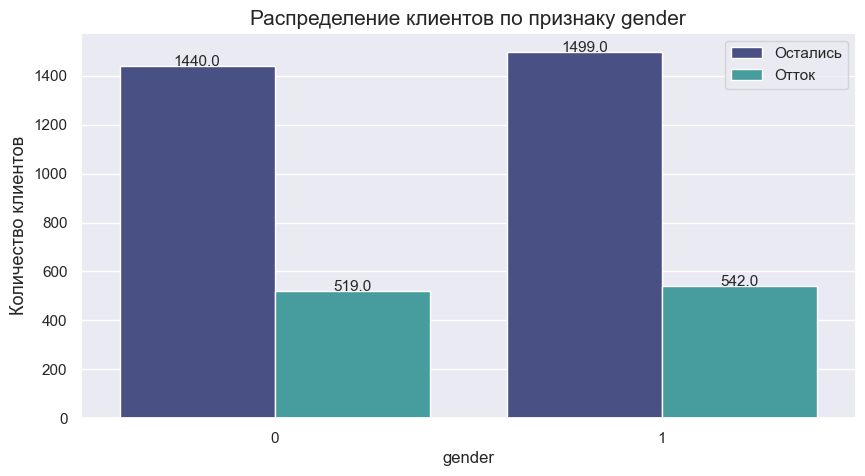


 доля ушедших 


,gender,total,churn,share
0,0,1959,519,0.26
1,1,2041,542,0.27


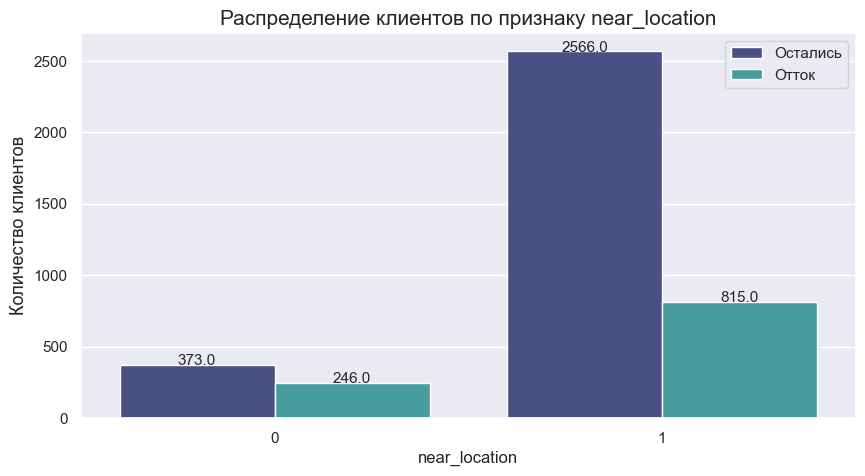


 доля ушедших 


,near_location,total,churn,share
0,0,619,246,0.40
1,1,3381,815,0.24


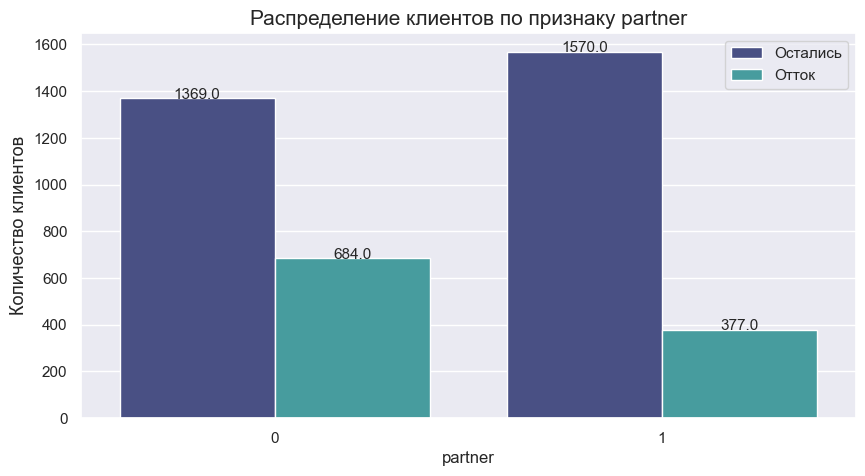


 доля ушедших 


,partner,total,churn,share
0,0,2053,684,0.33
1,1,1947,377,0.19


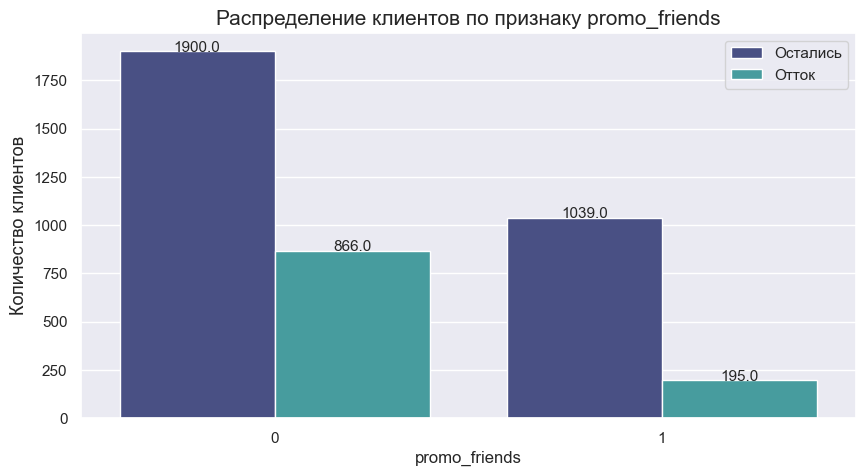


 доля ушедших 


,promo_friends,total,churn,share
0,0,2766,866,0.31
1,1,1234,195,0.16


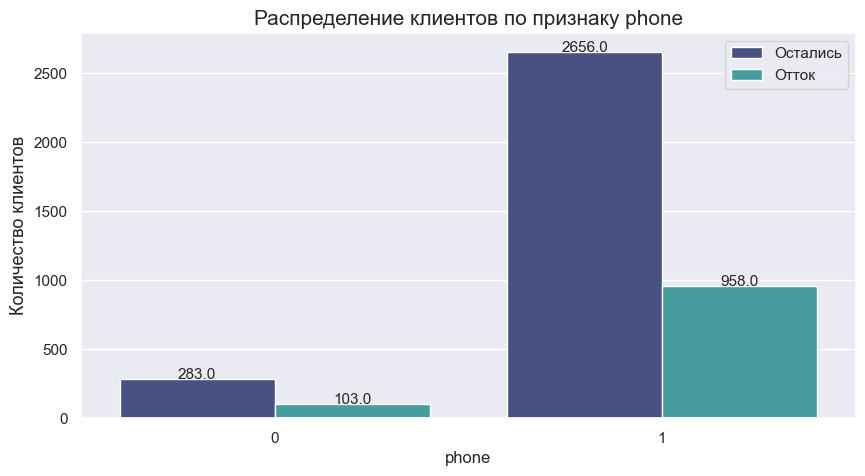


 доля ушедших 


,phone,total,churn,share
0,0,386,103,0.27
1,1,3614,958,0.27


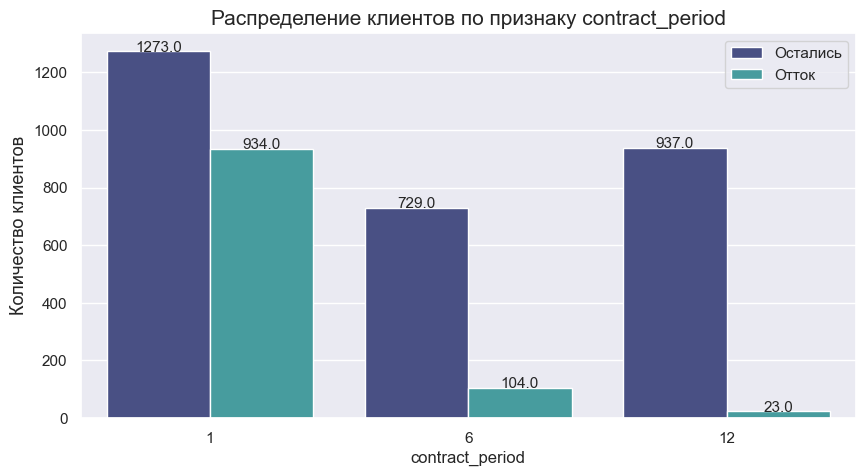


 доля ушедших 


,contract_period,total,churn,share
0,1,2207,934,0.42
1,6,833,104,0.12
2,12,960,23,0.02


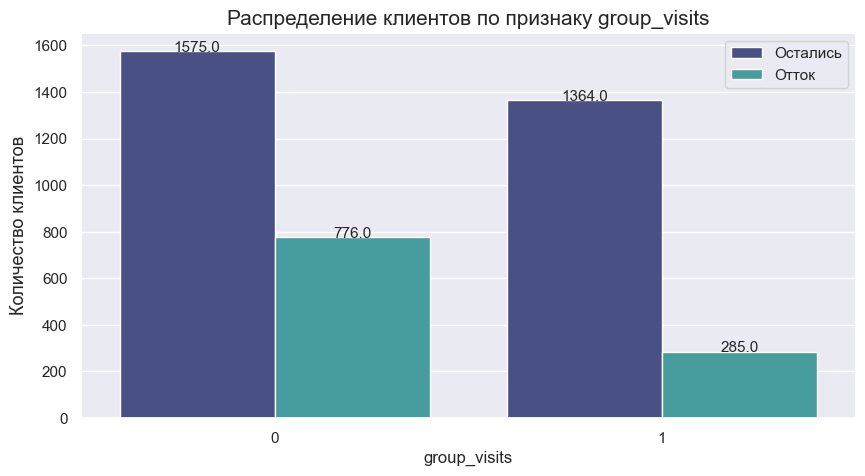


 доля ушедших 


,group_visits,total,churn,share
0,0,2351,776,0.33
1,1,1649,285,0.17


In [8]:
for feature in list_for_plot:
    countplt, ax = plt.subplots(figsize = (10,5))
    ax =sns.countplot(x = feature, data=gym, palette='mako', hue='churn')
    ax.set_title(f'Распределение клиентов по признаку {feature}',fontsize = 15)
    ax.set_xlabel(f'{feature}')
    ax.set_ylabel('Количество клиентов', fontsize = 13)
    for rect in ax.patches:
        ax.text (rect.get_x() + rect.get_width() / 2,
                 rect.get_height()+ 0.25,
                 rect.get_height(),
                 horizontalalignment='center', 
                 fontsize = 11)
    plt.legend(['Остались', 'Отток'])
    plt.show()
    print('')
    share = gym.groupby(feature).agg({'churn': ['count', 'sum']}).reset_index()
    share.columns = [feature, 'total', 'churn']
    share['share'] = round(share['churn'] / share['total'], 2)
    print('\033[7;30m доля ушедших \033[0m')
    display(share)

- как и в предыдущем пункте, половой признак и наличие контактной информации не влияют на отток клиентов - доли равны как среди оставшихся клиентов, так и попавших в отток
- чаще уходили в отток клиенты которые:
  - НЕ являются сотрудником компании-партнёра клуба
  - записались на первое занятие без использования промокода
  - НЕ посещали групповые занятия
  - у которых фитнес-клуб находится НЕпоблизости
  - и у которых длительность текущего абонемента составляет один месяц.  
  
**Рассмотрим числовые признаки**  

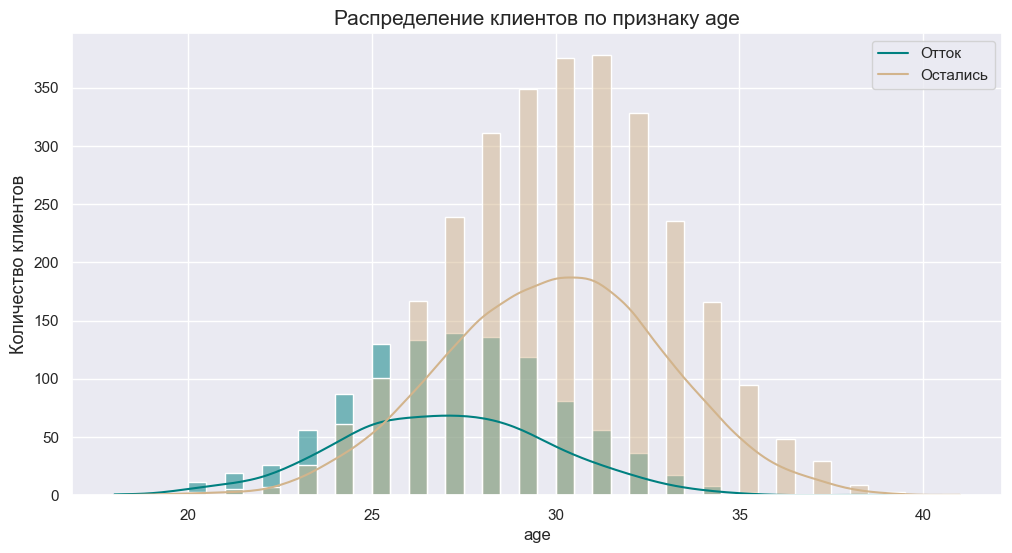

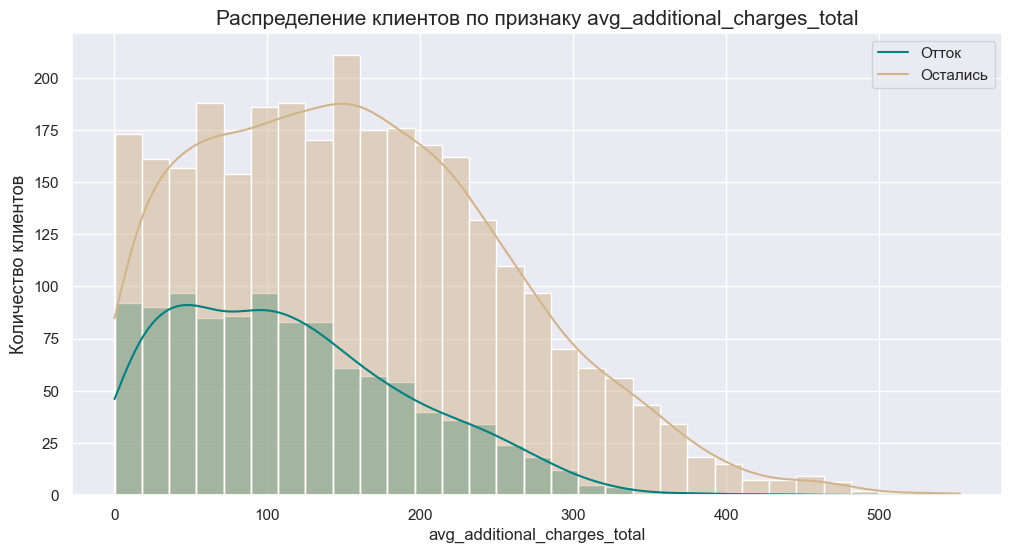

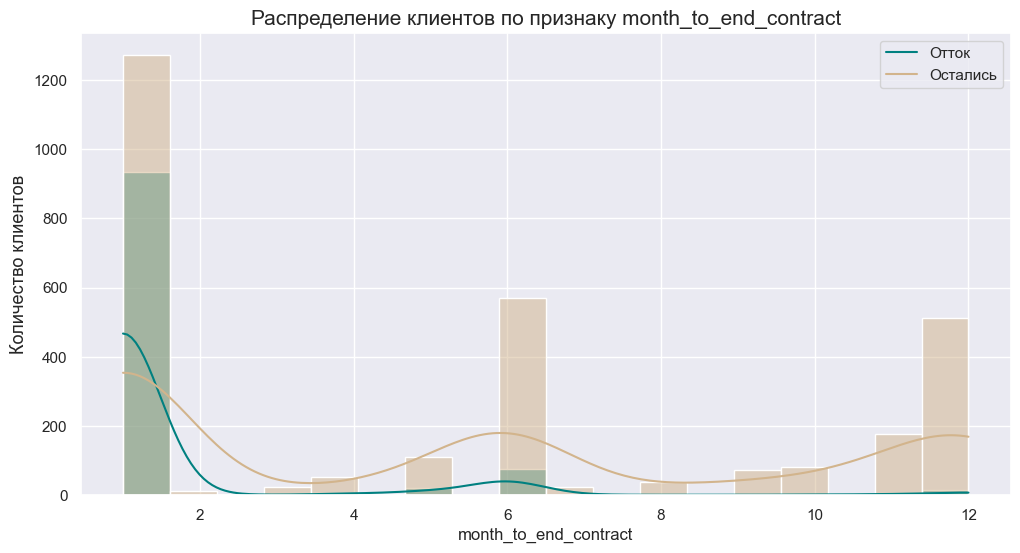

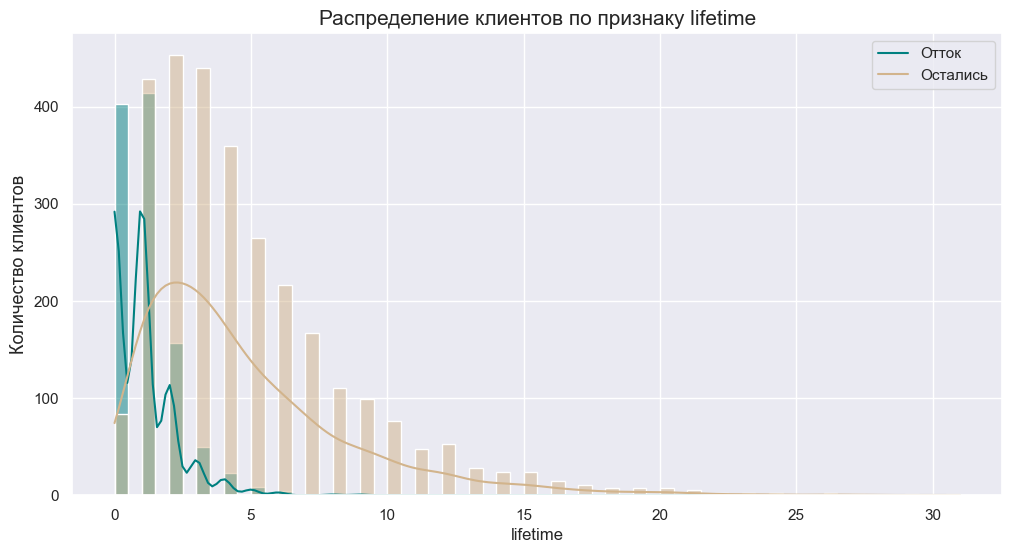

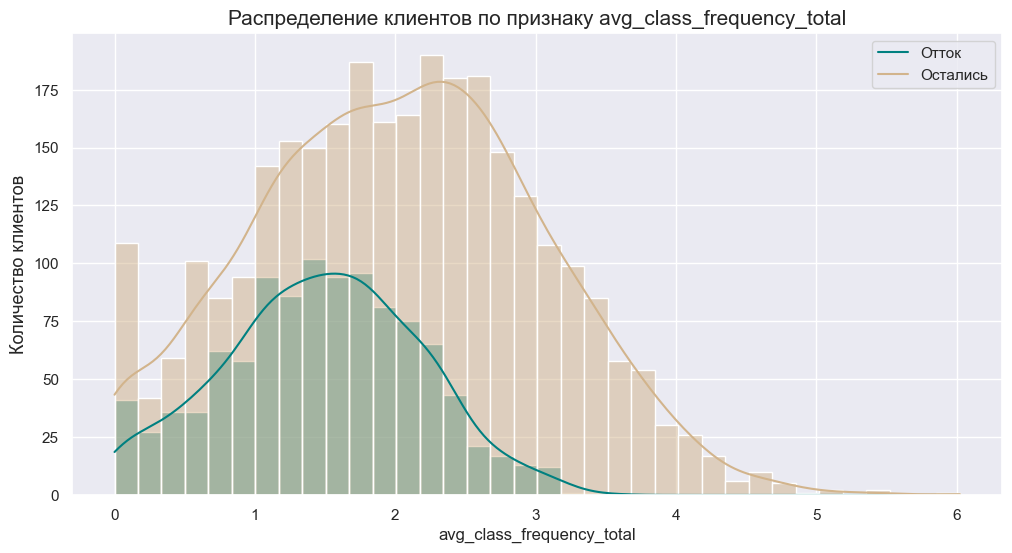

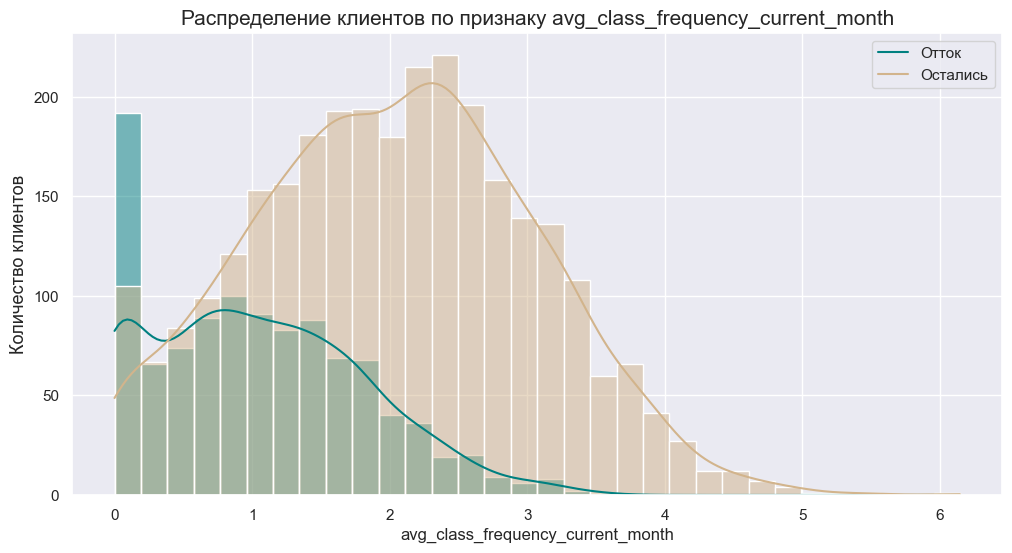

In [9]:
for column in gym.drop('churn', axis = 1).columns:
    if column not in list_for_plot:
        hist, ax = plt.subplots(figsize = (12,6))
        ax = sns.histplot(x = column, data=gym, palette=['tan', 'teal'], hue='churn', kde=True)
        ax.set_title(f'Распределение клиентов по признаку {column}',fontsize = 15)
        ax.set_xlabel(f'{column}')
        ax.set_ylabel('Количество клиентов', fontsize = 13)
        plt.legend(['Отток', 'Остались'])
        plt.show()

Среди данных признаков, чаще попадают в отток клиенты:
- в возрасте до 27 лет
- редко пользующиеся дополнительными услугами (либо тратящие небольшие суммы). Здесь прослеживается закономерность, что чем больше клиент тратит на дополнительные услуги, тем меньше доля клиентов, попавших в отток
- у которых до окончания действия абонемента остался месяц
- которые посещяют фитнес-клуб на протяжении 1-2 месяцев
- которые занимаются спортов 1-2 раза в неделю, а за предыдущий месяц не сходили в фитнес-центр ни разу или 1 раз.

Построим матрицу корреляций.  

Но прежде чем считать корреляцию Писрона, посмотрим на распределение числовых признаков, построим гисторгамы и "ящики с усами" и заодно проверим даные признаки на выбросы.

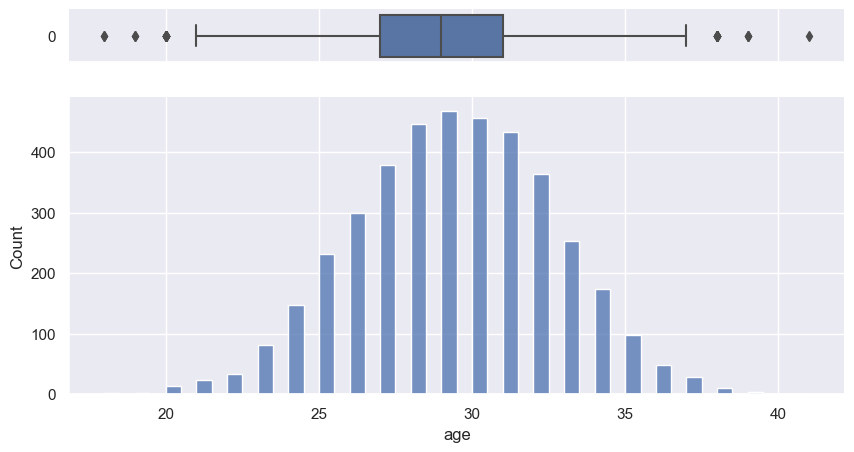

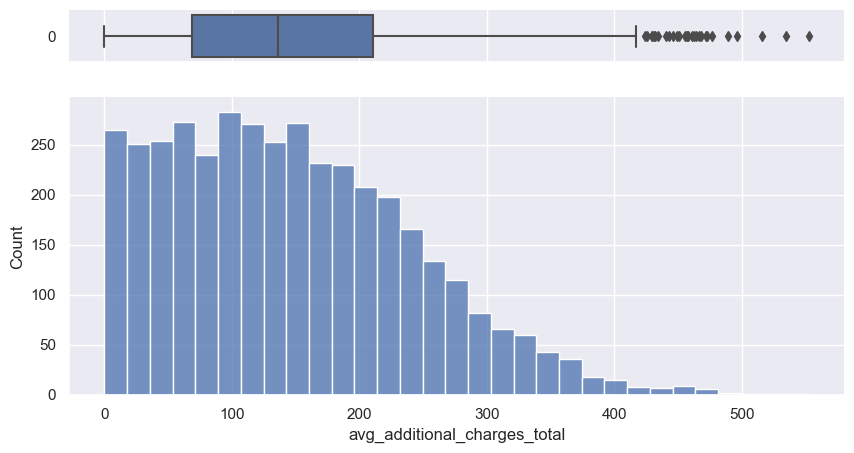

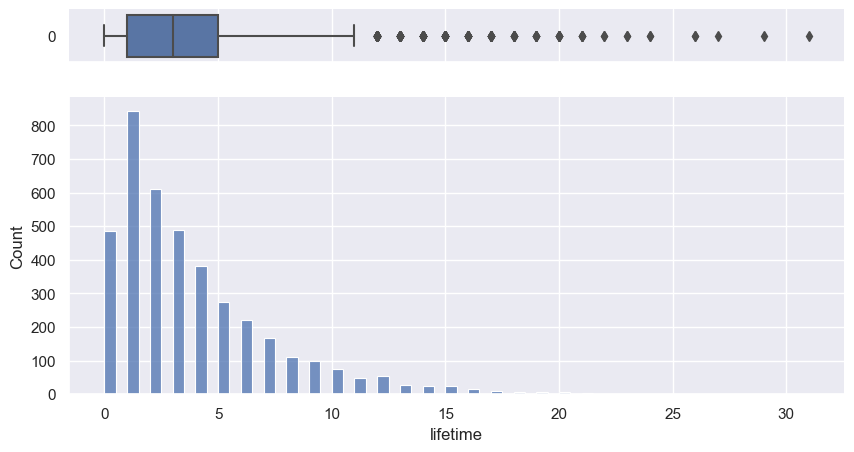

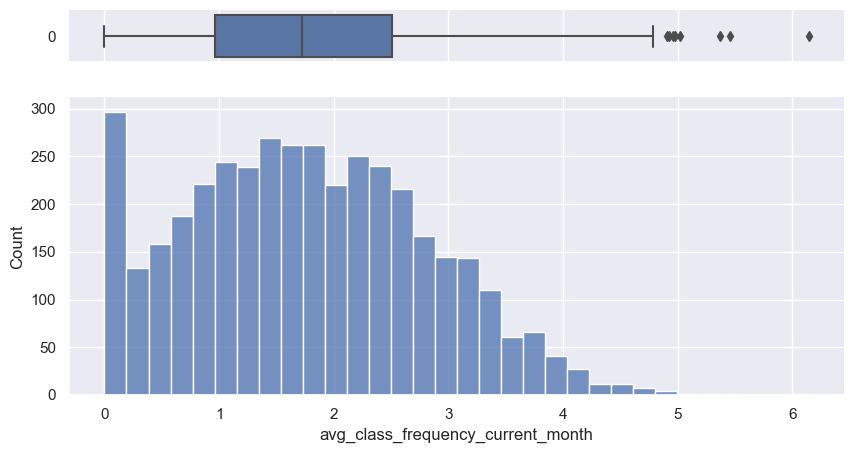

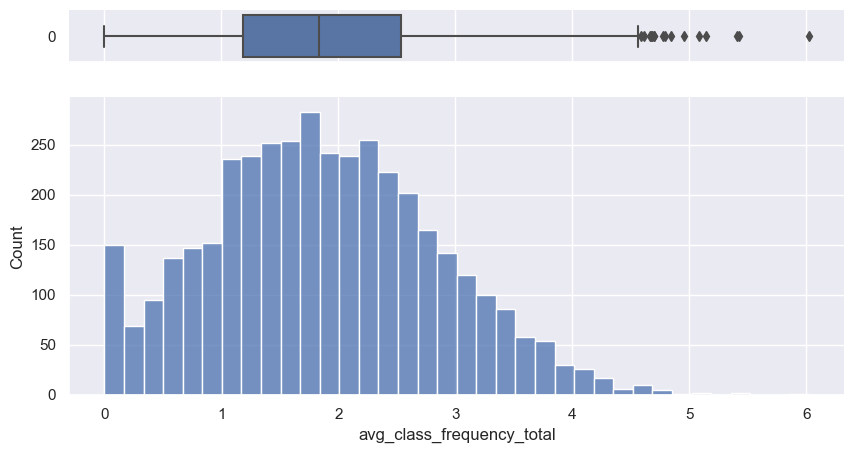

In [10]:
for feature in ['age', 
                'avg_additional_charges_total', 
                'lifetime', 
                'avg_class_frequency_current_month', 
                'avg_class_frequency_total']:
    f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, figsize=(10, 5), gridspec_kw={"height_ratios": (.15, .85)})
    sns.boxplot(gym[feature], orient="h", ax=ax_box)
    sns.histplot(gym[feature], ax=ax_hist)
    sns.despine(ax=ax_hist)
    sns.despine(ax=ax_box, left=True)

Данные признаки имеют нормальное распределение и, согласно графику boxplot, имеют правые хвосты, что данный график определяет как выбросы (возраст младше 20 и старше 37 за аномальные значения принимать не будем, их количество небольшое и такие клиенты имеют право быть). Рассмотрим эти хвосты детальнее и найдем 95 и 99 перцентили для принятия окончательного решения.

In [11]:
# признак суммарная выручка от доп.услуг

#display(gym.query('avg_additional_charges_total > 400'))
print(f'Количество клиентов (99 перцентиль): {len(gym.query("avg_additional_charges_total > 400"))}')
print(f'95 перцентиль: {np.percentile(gym["avg_additional_charges_total"], 95)}')
print(f'95 перцентиль: {np.percentile(gym["avg_additional_charges_total"], 99)}')

Количество клиентов (99 перцентиль): 44
95 перцентиль: 323.44087589030966
95 перцентиль: 400.9961250467456


In [12]:
# признак время с момента первого обращения в фитнес-центр

#display(gym.query('lifetime > 17'))
print(f'Количество клиентов (99 перцентиль): {len(gym.query("lifetime > 17"))}')
print(f'95 перцентиль: {np.percentile(gym["lifetime"], 95)}')
print(f'95 перцентиль: {np.percentile(gym["lifetime"], 99)}')

Количество клиентов (99 перцентиль): 37
95 перцентиль: 11.0
95 перцентиль: 17.0


In [13]:
# признак средняя частота посещений в неделю за предыдущий месяц

#display(gym.query('avg_class_frequency_current_month > 4'))
print(f'Количество клиентов (99 перцентиль): {len(gym.query("avg_class_frequency_current_month > 4"))}')
print(f'95 перцентиль: {np.percentile(gym["avg_class_frequency_current_month"], 95)}')
print(f'95 перцентиль: {np.percentile(gym["avg_class_frequency_current_month"], 99)}')

Количество клиентов (99 перцентиль): 73
95 перцентиль: 3.549061541419111
95 перцентиль: 4.185757787657458


In [14]:
# признак средняя частота посещений в неделю за все время

#display(gym.query('avg_class_frequency_total > 4'))
print(f'Количество клиентов (99 перцентиль): {len(gym.query("avg_class_frequency_total > 4"))}')
print(f'95 перцентиль: {np.percentile(gym["avg_class_frequency_total"], 95)}')
print(f'95 перцентиль: {np.percentile(gym["avg_class_frequency_total"], 99)}')

Количество клиентов (99 перцентиль): 72
95 перцентиль: 3.5356483663210474
95 перцентиль: 4.197579250683466


Проанализировав выводы и графики решаем удалить строки по показателю 99 перцентиля.

In [15]:
for feature in ['avg_additional_charges_total', 
                'lifetime', 
                'avg_class_frequency_current_month', 
                'avg_class_frequency_total']:
    perc_99 = np.percentile(gym[feature], 99)
    gym = gym[gym[feature] <= perc_99]

In [16]:
gym.shape

(3845, 14)

Было удалено 155 строк, что составило ~ 4% от всего датасета.

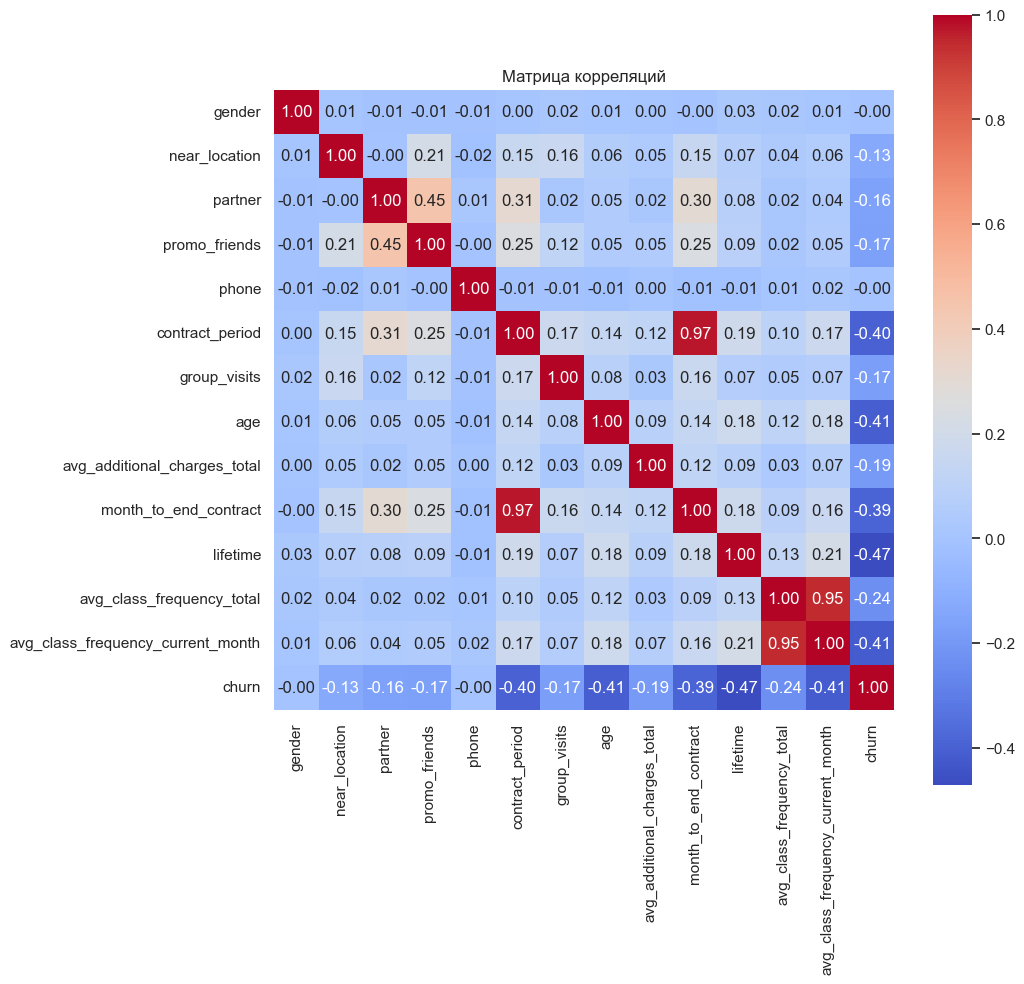

In [17]:
# строим матрицу корреляции

plt.figure(figsize=(10,10))
sns.heatmap(gym.corr(), annot=True, square=True, cmap='coolwarm', fmt='.2f')
plt.title('Матрица корреляций')
plt.show()

В общем, смотря на матрицу корреляции, можно сказать что большинство признаков никак не влияют друг на друга.  
Практически нулевая корреляция у признаков: пол клиента (gender) и наличие контактной информации (phone).  
Все признаки и целевая переменная (churn) имеют слабую или умеренную (среднюю) корреляционную связи, при этом заметим, что корреляция обратная, значит при усилении признака - снижается отток клиентов. Из признаков можно отметить возраст клиента (age - `-0.41`) и время с момента первого обращения в фитнес-центр (lifetime - `-0.47`).  
Умеренную среднюю корреляцию показывают признаки `partner` (сотрудник компании-партнёра) и `promo_friends` (первое посещение по промокоду) - 0,45.  
Сильную корреляционную связь показывают две пары переменных:
- `contract_period` (длительность текущего абонемента) и `month_to_end_contract` (срок до окончания абонемента) - 0,97
- `аvg_class_frequency_total` (средняя частота посещений в неделю) и `аvg_class_frequency_current_month` (средняя частота посещений в неделю за предыдущий месяц) - 0,95  

Такие признаки, с высокой корреляцией, вызывают мультиколлинеарность и переобучаемость модели. На практике рекомендуется удалить один из признаков (из пары коррелирующих), в нашем случае избавимся от столбцов: `month_to_end_contract` (срок до окончания абонемента) и `аvg_class_frequency_total` (средняя частота посещений в неделю).

In [18]:
# удалим коррелирующие признаки

gym.drop(['month_to_end_contract', 'avg_class_frequency_total'], axis=1, inplace=True)

Также стоить отметить о несбалансированности классов, а именно пропорции "оставшихся" клиентов и ушедших в отток, в нашем случае 27% (отток) : 73% ("оставшиеся")

**Промежуточные выводы**  

В данном разделе мы посмотрели на средние значения признаков по группам клиентов - кто ушел в отток и остался, построили графики распределения всех признаков относительно групп клиентов и матрицу корреляции всех признаков. На данном этапе можно сделать вывод, что:
- большинство клиентов все же остаются лояльными к сети фитнес-клубов
- чаще других в отток попадают клиенты:
  - в возрасте до 27 лет
  - со сроком действующего обонемента 1 месяц
  - посещающие фитнес-центр на протяжении 1-2 месяцев с момента первого обращения
  - посещающие фитнес-центр 1 раз в неделю
- пол клиента и наличие контактной информации не влияют на отток
- практически все признаки имеют слабую и умеренную корреляционную связи
- связь целевой переменной (churn) с остальными признаками отрицательная, что говорит о том, что при усилении признака - снижается отток клиентов, но признаков сильно связанных с оттоком клиентов не выявлено (максимум -0,47)
- обнаружены две пары мультиколлинеарных признаков: длительность текущего абонемента / срок до окончания абонемента и средняя частота посещений в неделю / средняя частота посещений в неделю за предыдущий месяц. Удалили по одному признаку из каждой пары, чтобы избежать переобучаемость модели
- отметили несбалансированность классов целевой переменной

## Шаг 3.  Модель прогнозирования оттока клиентов

Для прогнозирования оттока клиентов мы будем использовать модели бинарной классификации клиентов, где целевой признак — факт оттока клиента в следующем месяце.  
Обучим две модели - одну на основании алгоритма логистической регрессии (LogisticRegression), вторую - на основании алгоритма случайного леса (RandomForestClassifier) и сравним, какая из моделей показывает себя лучше.  

Для сравнения моделей будем использовать следующие метрики:
- Доля правильных ответов (accuracy)
- Точность (precision)
- Полнота (recall)  

Для начала разделим наши данные на признаки (Х) и целевую переменную (y), далее делим данные на обучающую и валидационную выборки (соотношение 80/20), т.к. у нас присутствует дисбаланс классов, добавим параметр `stratify`, который выполняет разделение таким образом, что доля значений в полученной выборке будет такой же, как доля значений, предоставленных этому параметру (т.е. 80/20):

In [19]:
X = gym.drop('churn', axis=1)
y = gym['churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

Приводим признаки к стандартному виду с помощью стандартизации (StandardScaler())

In [20]:
scaler = StandardScaler()
scaler.fit(X_train)

X_train_st = scaler.transform(X_train)
X_test_st = scaler.transform(X_test)

In [21]:
# задаем алгоритмы для моделей

lr_model = LogisticRegression(random_state=0)
rf_model = RandomForestClassifier(n_estimators=100, random_state=0)

# обучаем модели

lr_model.fit(X_train_st, y_train)
rf_model.fit(X_train, y_train) 

# прогнозы

lr_predictions = lr_model.predict(X_test_st)
rf_predictions = rf_model.predict(X_test) 

In [22]:
# функция для вывода метрик

def metrics(y_true, y_pred, model):
    print(f'Метрики модели {model}')
    print('Accuracy: {:.3f}'.format(accuracy_score(y_true, y_pred)))
    print('Precision: {:.3f}'.format(precision_score(y_true, y_pred)))
    print('Recall: {:.3f}'.format(recall_score(y_true, y_pred)))

In [23]:
metrics(y_test, lr_predictions, 'LogisticRegression')

Метрики модели LogisticRegression
Accuracy: 0.910
Precision: 0.833
Recall: 0.844


In [24]:
metrics(y_test, rf_predictions, 'RandomForestClassifier')

Метрики модели RandomForestClassifier
Accuracy: 0.887
Precision: 0.808
Recall: 0.774


По всем метрикам модель логистической регресси проявила себя лучше, ее значения ближе к единице. В нашем случае, главной метрикой будем считать `Recall`, т.к. она показывает, сколько реальных объектов `1` класса модель смогла обнаружить и  также нацелена на минимизацию рисков НЕ определить какой клиент потенциально в следующем месяце окажется в оттоке.  
В последующем, для определения оттока клиентов будем использовать модель логистической регрессии и, помимо остальных метрик, оценивать показатель метрики `Recall`.

После стандартизации значения коэффициентов при признаках отражают степень влияния каждого на финальный прогноз. Чем больше по модулю коэффициент, тем выше его влияние. Посмотрим какие признаки для каждой из моделей наиболее важные.

In [25]:
gym_lr = pd.DataFrame({'feature': X.columns, 'coeff': lr_model.coef_[0]})
gym_lr['coeff_abs'] = gym_lr['coeff'].abs()
display(gym_lr[['feature', 'coeff_abs']].sort_values(by='coeff_abs', ascending=False).head(5))

,feature,coeff_abs
9,lifetime,3.359352
5,contract_period,1.314138
7,age,1.170097
10,avg_class_frequency_current_month,1.157634
8,avg_additional_charges_total,0.497969


In [26]:
gym_rf = pd.DataFrame({'feature': X.columns, 'coeff': rf_model.feature_importances_})
display(gym_rf.sort_values(by='coeff', ascending=False).head(5))

,feature,coeff
9,lifetime,0.324876
10,avg_class_frequency_current_month,0.200927
7,age,0.145715
8,avg_additional_charges_total,0.120274
5,contract_period,0.113902


Для обеих моделей наиболее весомые признаки одинаковы: время с момента первого обращения, длительность абонемента, частота посещений, возраст и выручка от доп.услуг. Здесь все достаточно логично, ведь чем клиент чаще посещает фитнес-центр, пользуется доп.услугами, приобретает абонемент на длительный срок, тем он лояльнее и наоборот, но стоить отметить признак возраст (age) и его "высокий" уровень важности (топ-5 в обеих моделях), что не было очевидно при первоначальном анализе данных.

`На данном шаге исследования` мы разделили выборку на обучающую и валидационную, стандартизировали признаки, обучили модели и построили прогнозы. Обе модели показали себя неплохо, но по значениям метрик лидирует все же алгоритм `логистической регрессии`:
- метрика Accuracy показывает, что было определено правильно 91% прогнозов
- метрика Precision говорит, что среди целевого класса (`1`) доля правильных ответов составила 83.3%
- метрика Recall показывает, что 84.4% реальных объектов `1` класса смогли обнаружить с помощью модели  

Также рассмотрели наиболее важные признаки для модели: 
- время с момента первого обращения в фитнес-центр (в месяцах)
- длительность текущего действующего абонемента (в месяцах)
- средняя частота посещений в неделю
- возраст
- суммарная выручка от дополнительных услуг

## Шаг 4.  Кластеризация клиентов

Для задачи кластеризации клиентов будем использовать два наиболее популярных алгоритма: 
- Агломеративная иерархическая кластеризация
- K-Means  

Начнем с первого метода `Агломеративная иерархическая кластеризация`. При работе с данными алгоритмами необходима обязательная стандартизация данных

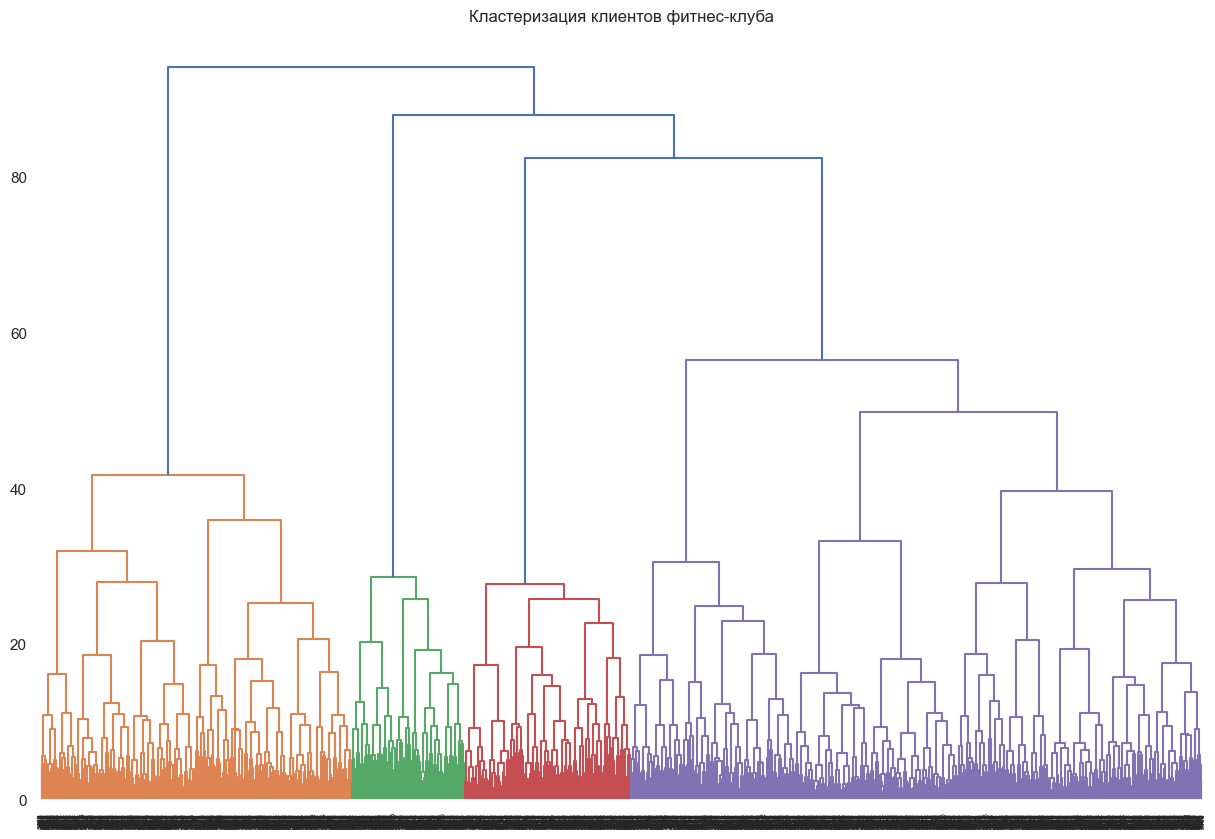

In [27]:
sc = StandardScaler()
X_sc = sc.fit_transform(X)

linked = linkage(X_sc, method = 'ward') 

plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.title('Кластеризация клиентов фитнес-клуба')
plt.show() 

Согласно дендрограмме, аглоритм предлагает разделить клиентов на 4 кластера. Мы видим что фиолетовая часть получилась значительно больше остальных, потенциально ее можно было бы разделить еще на 2 кластера и получить в итоге 5 кластеров, именно такое количество кластеров мы зададим для следующего алгоритма K-Means.

`K-Means`

In [28]:
sc = StandardScaler()
X_sc = sc.fit_transform(X)

km = KMeans(n_clusters=5, random_state=0) 
labels = km.fit_predict(X_sc)

Посмотрим на значение `метрики силуэта`

In [29]:
silhouette_score(X_sc, labels)

0.13780336512040162

Данная метрика принимает значения от -1 до 1, где -1 говорит нам о том что кластеры назначены неправильным образом, а 1 означает, что кластеры находятся на значительном расстоянии друг от друга и четко различимы и чем ближе значение метрики к единице, тем лучше. В нашем случае показатель метрики силуэта равен 0,14, что говорит о том, что расстояние между кластерами практически несущественно, вероятно следовало придерживаться кластеризации, предложенной дендрограммой)   

Посмотрим на количество клиентов по кластерам и средние значения признаков.

In [30]:
gym['clasters'] = labels

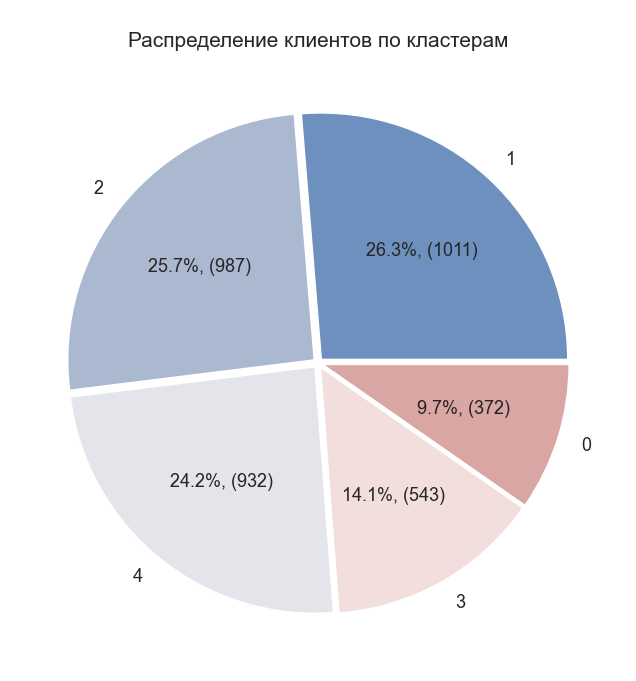

In [31]:
value = gym['clasters'].value_counts()
(gym['clasters']
 .value_counts()
 .plot(kind='pie', 
       figsize=(8,8), 
       autopct=lambda p:f'{p:.1f}%, ({p*sum(value)/100 :.0f})',
       explode=(0.02, 0.02, 0.02, 0.02, 0.02),
       textprops = {"fontsize":13},
       colors=sns.color_palette('vlag'))
)
plt.title('\nРаспределение клиентов по кластерам', fontsize = 15)
plt.ylabel('')
plt.show()

Самые многочисленные кластеры 1, 2 и 4 - примерно с равным количеством клиентов (1011, 987 и 932 соответственно) что составляет 24.2 - 26.3% от общего количества. В два раза меньше клиентов в третьем кластере (543) и самый немногочисленный кластер - 0 (372 клиентов или 9.7% от общего количества).  

Далее рассмотрим средние значения признаков и долю оттока клиентов по кластерам

In [32]:
mean_value = gym.groupby('clasters').mean().T
mean_value.style.highlight_min(color="#d1e2f2", axis=1).highlight_max(color="#99bfe2", axis=1)

clasters,0,1,2,3,4
gender,0.526882,0.479723,0.557244,0.500921,0.498927
near_location,0.860215,1.000000,0.996960,0.000000,0.995708
partner,0.467742,0.220574,0.376900,0.488029,0.896996
promo_friends,0.311828,0.082097,0.012158,0.081031,1.000000
phone,0.000000,1.000000,1.000000,1.000000,1.000000
contract_period,4.760753,2.091988,5.931104,2.955801,7.010730
group_visits,0.419355,0.291790,0.512665,0.226519,0.513948
age,29.284946,27.532146,30.655522,28.637201,29.589056
avg_additional_charges_total,143.177115,116.099673,169.288880,133.840228,151.320988
lifetime,3.653226,1.737883,5.090172,2.854512,4.207082


In [33]:
share = gym.groupby('clasters').agg({'churn': ['count', 'sum']}).reset_index()
share.columns = ['claster', 'total', 'churn']
share['share'] = round(share['churn'] / share['total'], 2)
print('\033[1;34m доля оттока по кластерам \033[0m')
display(share[['claster', 'share']])

 доля оттока по кластерам 


,claster,share
0,0,0.28
1,1,0.59
2,2,0.02
3,3,0.41
4,4,0.12


Согласно полученным данным, всех клиентов в кластерах можно охарактеризовать следующим образом:
- кластер 0 - `рыбы`. Самый немногочисленный кластер, кажется данные клиенты сами еще не определились, хотят они посещать фитнес-клуб или нет, практически все живут/работают поблизости, приблизительно половина клиентов пришла от компаний-партнеров, одной трети данный клуб порекомендовали друзья. Все признаки показывают промежуточные значения, единственная отличительная особенность - это отсутствие контактной информации у всех клиентов. Средняя длительность текущего действующего абонемента 4-5 месяцев и среднее время с момента первого посещения клуба ~ 4 месяца, чуть больше половины посещает групповые занятия, средний возраст 29 лет. Отток составляет 28%.  
- кластер 1 - `ленивцы`. Самый многочисленный кластер (1011 клиентов) в который входят самые молодые клиенты, живут/работают рядом, но ходят на тренировку в среднем раз в неделю, приобретают короткие абонементы, тратят мало, групповые занятия посещают редко, пришли не по промо/от партнеров. Клиенты данного кластера показывают самый высокий уровень оттока (59%), вероятнее всего через месяц часть из них попрощается. 
- кластер 2 - `пантеры`. Второй по многочисленности кластер (987 клиентов). Сильные и "преданные" клубу клиенты. Лидируют по показателю `lifetime` (более 5-ти месяцев), приобретают долгосрочные абонементы, посвящают спорту 2 дня в неделю и более и с удовольствием посещают групповые занятия. Средний возраст 30-31 год, охотно пользуются дополнительными услугами центра и имеют самый низкий показатель оттока (2%), ближайшее время уходить не планируют.
- кластер 3 - `птички`. Немногочисленный кластер (543 человек). Живут или работают вдали от фитнес-центра, половина клиентов является сотрудниками компании-партнёра клуба, посещают занятия по возможности, но в среднем 1-2 раза в неделю, в большей степени предпочитают самостоятельные занятия (не в группах), 3 месяца - средняя продолжительность абонемента и среднее время с момента первого обращения. Средний возраст 28-29 лет, пользуются доп.услугами, но не очень охотно, показатель оттока - 41%, что говорит о возможности "птичек" в скором времени улететь в жаркие страны.
- кластер 4 - `неразлучники`. Все клиенты пришли по рекомендации друзей либо являются сотрудниками компании-партнёра клуба, живут либо работают рядом, в среднем посещают центр вот уже 4 месяца (2 раза в неделю) и не готовы расставаться, приобретая абонемент на 7 месяцев и более. Средний возраст 29-30 лет, любители воспользоваться доп.услугами и редко прекращают "дружить" с клубом.  


Построим распределения для признаков по кластерам

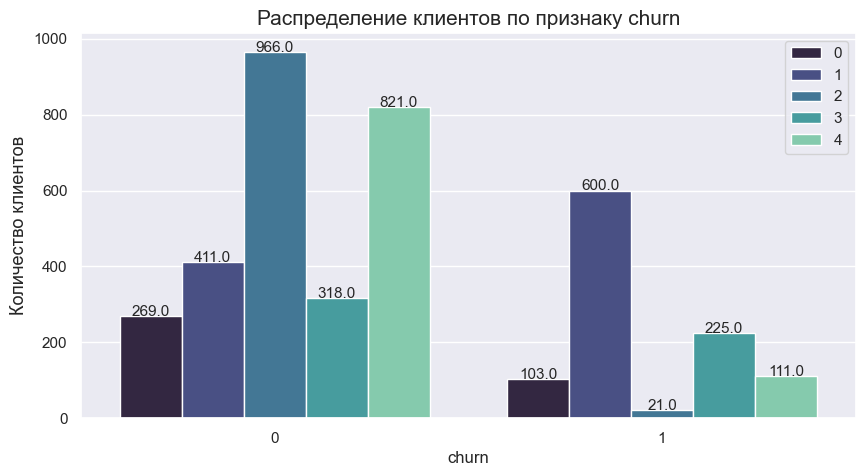

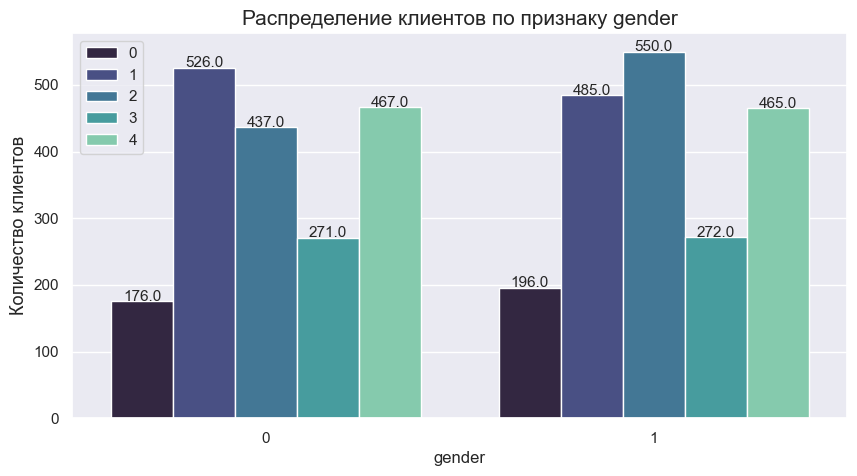

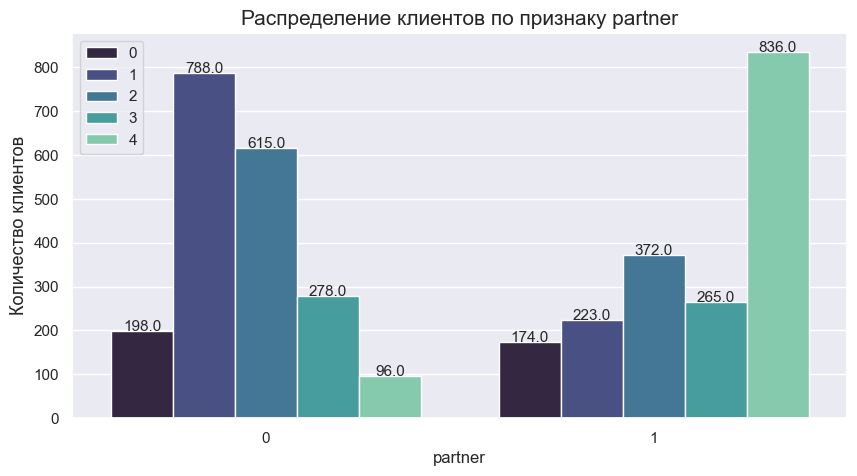

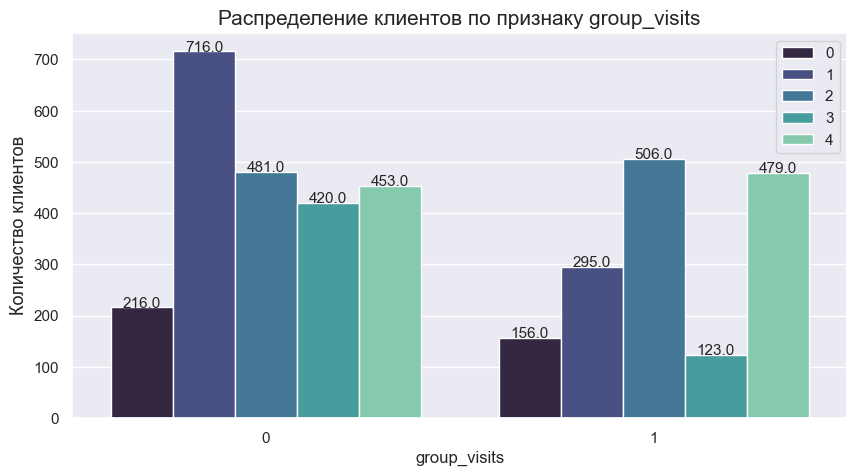

In [34]:
for column in ['churn', 'gender', 'partner', 'group_visits']:
    countplt, ax = plt.subplots(figsize = (10,5))
    ax =sns.countplot(x = column, data=gym, palette='mako', hue='clasters')
    ax.set_title(f'Распределение клиентов по признаку {column}',fontsize = 15)
    ax.set_xlabel(f'{column}')
    ax.set_ylabel('Количество клиентов', fontsize = 13)
    for rect in ax.patches:
        ax.text (rect.get_x() + rect.get_width() / 2,
                 rect.get_height()+ 0.25,
                 rect.get_height(),
                 horizontalalignment='center', 
                 fontsize = 11)
    plt.legend(loc='best')
    plt.show()
    print('')

Данные графики подтверждают приведенную выше характеристику для кластеров:
- по степени оттока самыми преданными остаются клиенты кластера 2 и 4 (пантеры и неразлучники), в зоне риска клиенты из 1-го кластера (ленивцы)
- половой признак стабильно показывает отношение 50/50 по всем кластерам
- больше всего по партнерской программе пришло клиентов 4-го кластера
- охотнее всего посещают групповые занятия клиенты кластера 2 и 4 (пантеры и неразлучники), избегают такую активность - ленивцы (кластер 1)

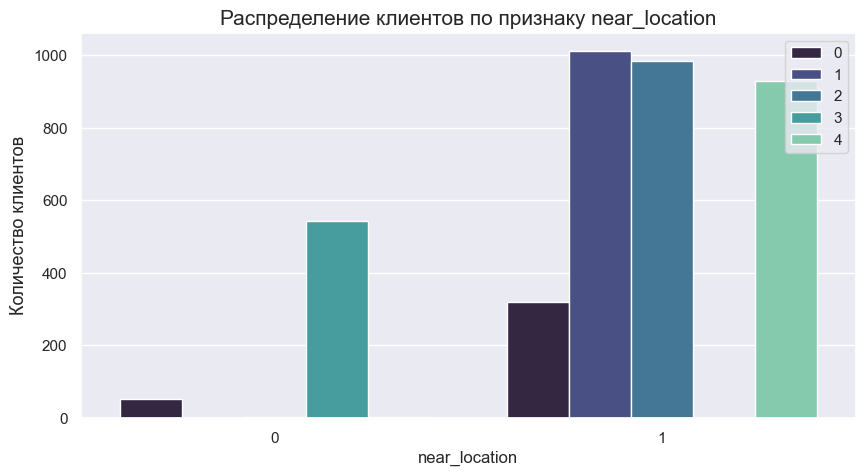

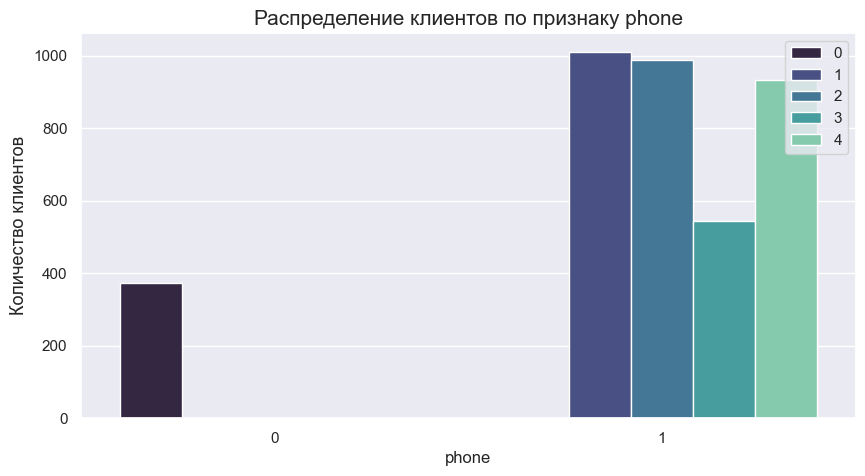

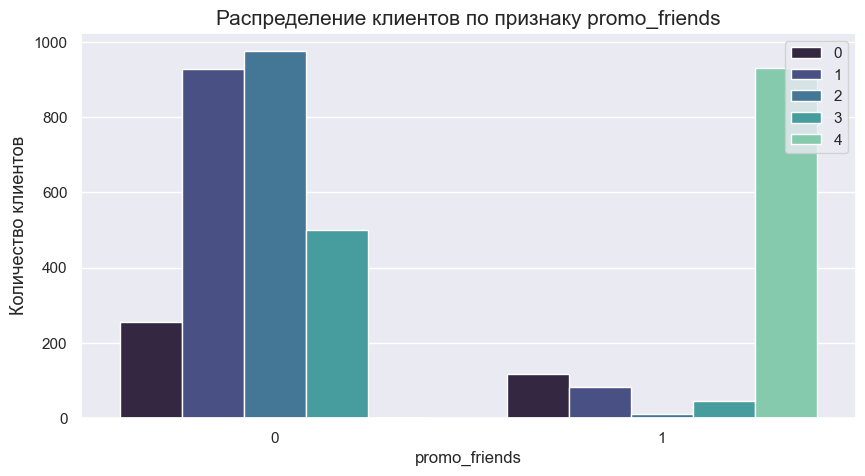

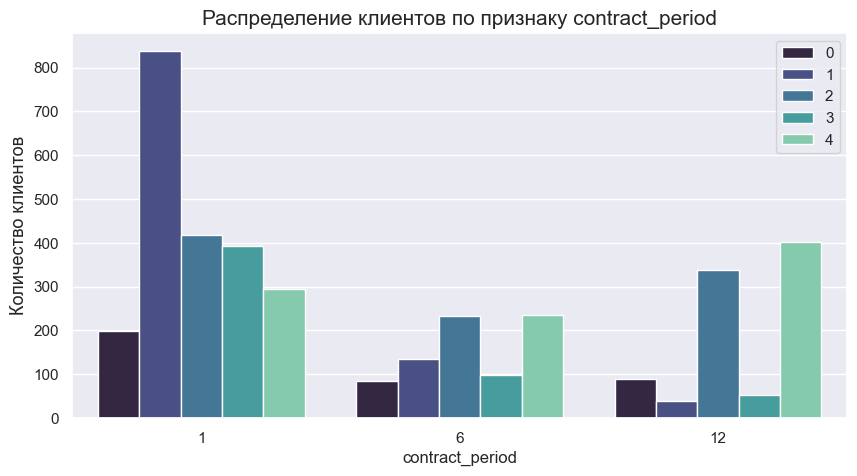

In [35]:
for column in ['near_location', 'phone', 'promo_friends', 'contract_period']:
    countplt, ax = plt.subplots(figsize = (10,5))
    ax =sns.countplot(x = column, data=gym, palette='mako', hue='clasters')
    ax.set_title(f'Распределение клиентов по признаку {column}',fontsize = 15)
    ax.set_xlabel(f'{column}')
    ax.set_ylabel('Количество клиентов', fontsize = 13)
    plt.legend(loc='upper right')
    plt.show()
    print('')

- единственный кластер, где клиенты живут либо работают далеко от фитнес-центра - 3й кластер (птички)
- только в 0м кластере отсутствует контактная информация клиентов
- все клиенты 4го кластера записались по приглашению друзей, клиенты кластеров 1 и 2 в большей степени записались в фитнес центр без указания промо-кодов
- ленивцы (кластер 1) приобретают абонементы на месяц, на более долгий период предпочтительнее берут клиенты кластеров 2 и 4.

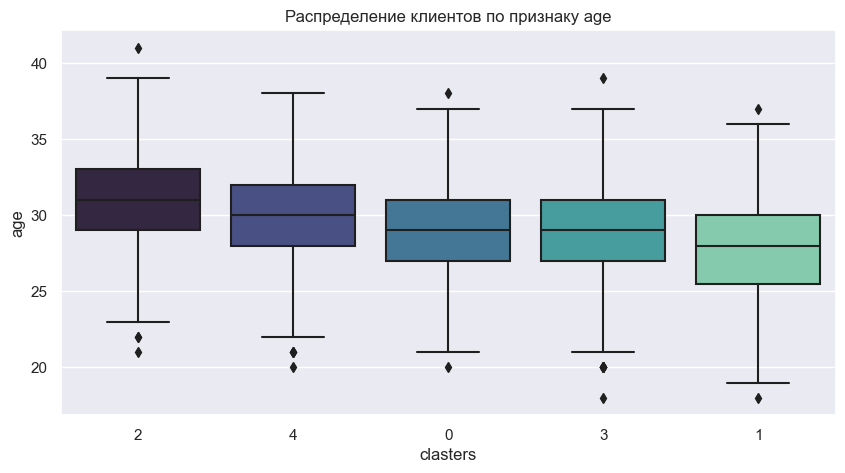

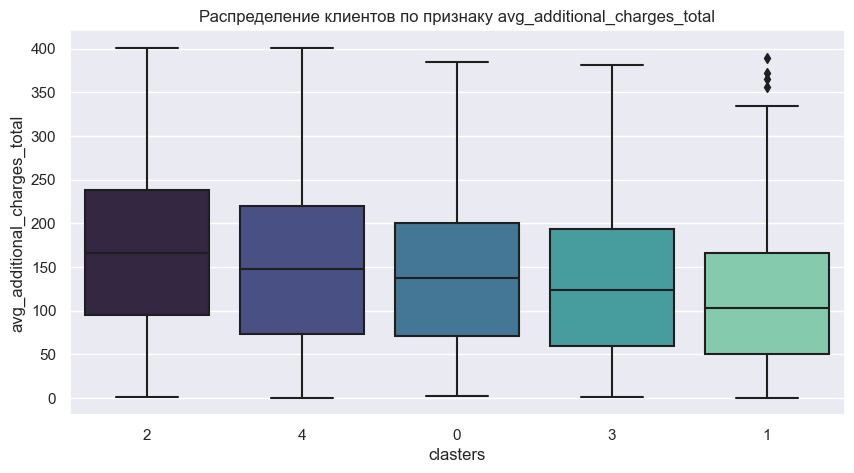

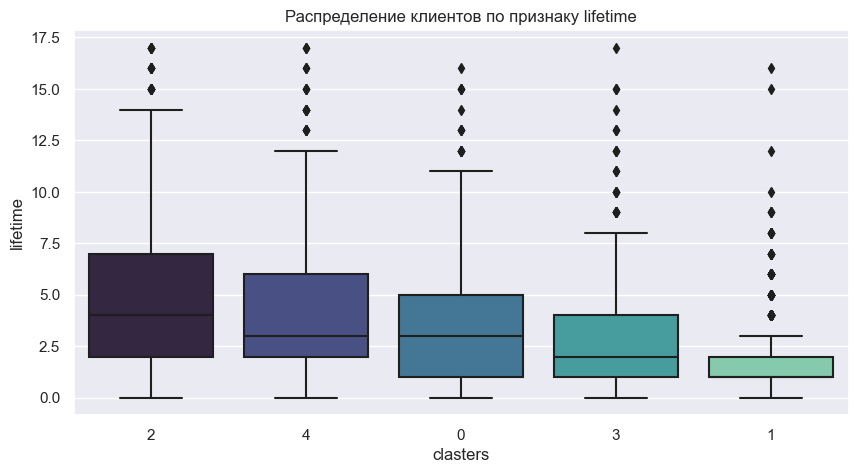

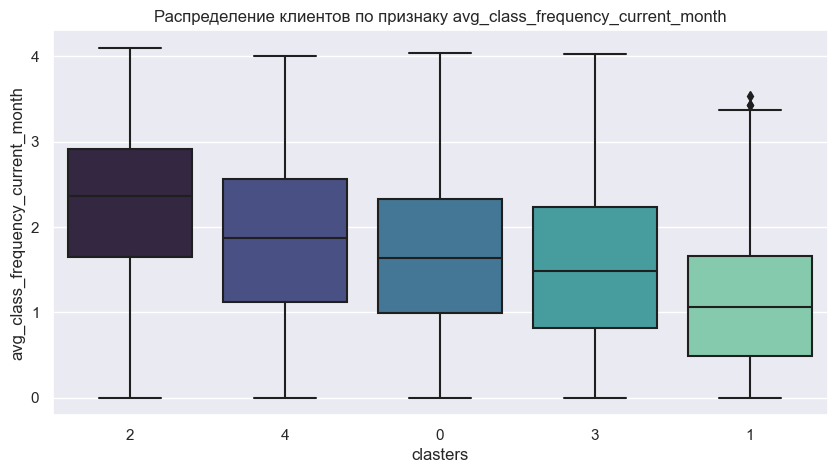

In [36]:
for column in ['age', 'avg_additional_charges_total', 'lifetime', 'avg_class_frequency_current_month']:
    mean_by_column = gym.groupby(['clasters'])[column].mean().sort_values(ascending=False)
    plt.figure(figsize=(10,5))
    sns.boxplot(x='clasters', y=column, data=gym, palette='mako', order=mean_by_column.index)
    plt.title(f'Распределение клиентов по признаку {column}')
    plt.show()

На данных графиках отлично прослеживается направленность,  
можно заметить что самые высокие показатели у кластера 2 и далее в порядке 4 -> 0 -> 3 -> 1 до самого низкого значения, поэтому-то клиенты 0-го кластера охарактеризованы как неопредилившиеся, ни минимум, ни максимум, они просто есть) 1-й кластер - ленивцы с самыми низкими показателями, ну и гроза спорта - пантера, лидирует по всем показателям.  
Так среди числовых признаков
- 2 кластер: более взрослые клиенты (~ 31 год), тратят больше остальных на доп.услуги, дольше всех посещают фитнес-клуб и чаще остальных ходят на тренировки в неделю
- кластеры 4, 0 и 3 занимают промежутоные значения по данным признакам
- и клиенты кластера 1 являются самыми молодыми (~ 27 лет), тратят меньше остальных на доп.услуги, познакомились с данным фитнес-центром не так давно и посещают занятия редко (1 раз в неделю).


На данном этапе исследования мы разделили всех наших клиентов на кластеры.  
Согласно агломеративной иерархической кластеризации график дендрограммы предложил разделить всех клиентов на 4 кластера.  
Далее мы применили алгоритм K-Means и разделили клиентов на 5 кластеров, посмотрели на средние значения признаков по получившимся кластерам и долю оттока клиентов, изучили распределение признаков в каждом кластере.  
Среди выявленных 5-ти кластеров мы можем наблюдать некоторую схожесть между некоторыми из них, поэтому для формирования портрета типичного клиента для каждого кластера мы бы предложили выделить следующие группы:
- кластер 2 и кластер 4 самые надежные клиенты (к тому же одни из многочисленных кластеров). Проживают либо работают поблизости, приобретают долгосрочные абонементы, с удовольствием посещают групповые занятия и не скупятся на дополнительные услуги. Средний возраст клиента 29-31 год, посещают фитнес-центр вот уже более 4х месяцев в среднем 2 раза в неделю и более. Показывают самый низкий процент оттока: кластер 4 - 12%, кластер 2 - 2%.
- кластер 0 и кластер 3 занимают последние два места по численности клиентов, показывают промежуточные значения по средним показателям признаков: средний возраст 28-29 лет, половина клиентов являются сотрудниками компании-партнера клуба, в среднем приобретают абонемент на 3-5 месяцев, групповые занятия посещают, но менее охотно. На дополнительные услуги в среднем тратят 133-143 у.е. (максимальный показатель 169 у.е. у кластера 2), посещают фитнес-центр 1-2 раза в неделю на протяжении 3-4 месяцев с момента первого обращения. Единственное весомое отличие среди данных кластеров - клиентам 3го кластера приходится добираться до фитнес-клуба, тогда как клиенты кластера 0 живут или работают в непосредственной плизости. Процент оттока составляет: кластер 3 - 41%, кластер 0	- 28%.
- кластер 1. Самая многочисленная (1011 клиентов) и самая ненадежная группа. Молодые клиенты (~ 27 лет), живут либо работают поблизости, но посещают фитнес-центр редко 1 раз в неделю и реже, приобретают короткие абонементы, тратят мало, групповые занятия посещают редко, записались на первое занятие самостоятельно (без промо-кодов и партнерских программ). Среди всех кластеров имеют максимальный процент оттока - 59%.

## Шаг 5.  Выводы и рекомендации

На основании предоставленных данных о клиентах фитнес-клуба мы провели анализ с целью подготовить план действий по удержанию клиентов. Наше исследование состояло из нескольких этапов, главные выводы по ним:  
- **выгрузка и предобработка данных**  

В предоставленных данных содержится 4 тысячи строк, пропуски и дубликаты отсутствуют. Привели в порядок наименование столбцов и поменяли тип данных для столбца `month_to_end_contract`, рассмотрели основные признаки клиентов.  

- **исследовательский анализ данных**  

Рассмотрели средние значения признаков по группам клиентов - кто ушел в отток и остался, построили графики распределения всех признаков относительно групп клиентов и матрицу корреляции всех признаков. Таким образом: `большинство клиентов все же остаются лояльными к сети фитнес-клубов`, чаще других в отток попадали клиенты в возрасте до 27 лет, со сроком действующего обонемента 1 месяц, имеющие короткий срок знакомства с фитнес-центром (1-2 месяца) и посещающие тренировки раз в неделю и реже. `Пол клиента и наличие контактной информации не влияют на отток`. Проверили численные признаки на выбросы и удалили сильно выбивающиеся значения в 4х столбцах по 99 перецентиле (155 строк - 4% от датасета). Согласно матрицы корреляции связь целевой переменной (churn) с остальными признаками отрицательная, что говорит о том, что при усилении признака - снижается отток клиентов, но признаков сильно связанных с оттоком клиентов на данном этапе не выявленно (максимум -0,47). Было обнаружено две пары мультиколлинеарных признаков, чтобы избежать переобучаемость модели было принято решение удалить по одному признаку из каждой пары. 

- **прогнозирование оттока клиентов**  

Для прогноза оттока клиентов мы использовали два алгоритма: логистическая регрессия и случайный лес. Для оценки моделей использовали три метрики, согласно которым модель логистической регрессии проявила себя лучше. Выявили признаки, оказывающие бОльшее влияние на модель: время с момента первого обращения в фитнес-центр, длительность действующего абонемента, средняя частота посещений в неделю, возраст и суммарная выручка от дополнительных услуг  

- **кластеризация клиентов**  

График дендрограммы предложил разделить всех клиентов на 4 кластера. Далее, используя алгоритм к-средних мы разделили клиентов на 5 кластеров, рассмотрели средние значения признаков по получившимся кластерам и долю оттока клиентов, изучили распределение признаков в каждом кластере. Среди выявленных кластеров наблюдалась схожесть между некоторыми из них, поэтому для формирования портрета типичного клиента для каждого кластера было предложено разделить клиентов на следующие группы:  
  - Самые надежные - кластер 2 и кластер 4 (к тому же одни из многочисленных кластеров). Проживают/работают поблизости, приобретают долгосрочные абонементы, с удовольствием посещают групповые занятия и не скупятся на дополнительные услуги. Средний возраст клиента 29-31 год, посещают фитнес-центр вот уже более 4х месяцев в среднем 2 раза в неделю и более. Показывают самый низкий процент оттока: кластер 4 - 12%, кластер 2 - 2%.  
  - Средние показатели - кластер 0 и кластер 3, занимают последние два места по численности клиентов, средний возраст 28-29 лет, половина клиентов являются сотрудниками компании-партнера клуба, в среднем приобретают абонемент на 3-5 месяцев, групповые занятия посещают, но менее охотно. На дополнительные услуги в среднем тратят 133-143 у.е. (максимальный показатель 169 у.е. у кластера 2), посещают фитнес-центр 1-2 раза в неделю на протяжении 3-4 месяцев с момента первого обращения. Единственное весомое отличие среди данных кластеров - клиентам 1го кластера приходится добираться до фитнес-клуба, тогда как клиенты кластера 4 живут или работают в непосредственной плизости. Процент оттока составляет: кластер 3 - 41%, кластер 0	- 28%.  
  - Ненадежные - кластер 1. Самая многочисленная (1011 клиентов) группа. Молодые клиенты (~ 27 лет), живут либо работают поблизости, но посещают фитнес-центр редко 1 раз в неделю и реже, приобретают короткие абонементы, тратят мало, групповые занятия посещают редко, записались на первое занятие самостоятельно (без промо-кодов и партнерских программ). Среди всех кластеров имеют максимальный процент оттока - 59%.  
  
  

- **рекомендации для стратегии взаимодействия с клиентами и их удержания**  

Мы определили три значимые группы для сети фитнес-клубов. Исходя из их характеристик мы рекомендуем следующее:
- для клиентов из надежной группы. Контролировать основные показатели, такие как частота посещений в неделю, посещение групповых занятий, продление абонементов и среднемесячную выручку от дополнительных услуг. При обнаружении снижения показателей персонально предлагать различные скидки и акции для их удержания.
- клиенты со средними показателями. Настроить маркетинговую политику на увеличение средних ежемесячных показателей, чтобы перевести их в категорию надежных. Например при продлении абонемента на более долгий период предлагать доп.услуги в подарок или занятие с тренером в подарок и т.д.
- для ненадежной группы. Чтобы не тратить деньги компании напрасно, с помощью модели прогнозироввать клиентов, потенциально переходящих в отток и уже персонально подбирать какую скидку или акцию им предоставить.  

Исходя из признаков наиболее влияющих на отток клиентов мы также рекомендуем мотивировать клиентов пользоваться дополнительными услугами (уникальная продукция, спорт.питание, услуги массажа после тренировки и т.д.), чаще посещать групповые занятия (провести опрос, что именно им интересно, возможно им не хватает тренировок по самбо)) и фитнес-центр в целом. 